# インシデント調査

M先輩から「このサーバがちょっと怪しいくって調査したいから、[インシデントレスポンス第3版](https://www.amazon.co.jp/dp/4822279871/)のp179に載ってるサーバの調査コマンド一式の結果のレポート作って。あ、あと、ポートが1つ LISTEN になってて http サーバになってるはずなんで、それが動いてるかも確認しといて。」と指示があった。

前回作業を踏まえて今回も作業するが、今後も同様の作業がありそうなので、リファクタリングしておく。

M先輩から「サービス止めないでファイルシステム舐めたりしてるので、作業が与えるサーバの負荷は気になる」とコメントがあったので、適時ロードアベレージを取っておくことにする。（コードは別のとこで作ったものを持ち込んだ）

システムの負荷状態を記録しておく。

In [1]:
!pip install parse

  Running setup.py bdist_wheel for parse ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/d9/25/e7/8f6f6a0e923b019d09148f5ea711333b94fab03f585e990eee
Successfully built parse


In [2]:
import datetime
JST = datetime.timezone(datetime.timedelta(hours=+9), 'JST')

import parse

uptime_list = []

uptime_str = !uptime
uptime_clumn = parse.parse("{}load average: {:g}, {:g}, {:g}", uptime_str[0])
uptime_clumn = list(uptime_clumn)[1:]
uptime_clumn.insert(0, datetime.datetime.now(JST))
uptime_list.append(uptime_clumn)
print(uptime_list)

[[datetime.datetime(2018, 6, 4, 15, 33, 6, 58195, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 0.08, 0.04, 0.08]]


# ライブレスポンス実施

## 事前準備

[作業対象のコンテナ](https://hub.docker.com/r/mnagaku/lc-minimal-notebook/)では、環境変数でTZ変えれるので、JSTに設定する。

In [3]:
%env TZ JST-9

env: TZ=JST-9


コマンドの追加インストール。

In [4]:
!sudo apt-get update
!sudo apt-get upgrade -y
!sudo apt-get install -y sysv-rc-conf kmod lsof

Get:1 http://archive.ubuntu.com/ubuntu xenial InRelease [247 kB]
Get:2 http://security.ubuntu.com/ubuntu xenial-security InRelease [107 kB]
Get:3 http://archive.ubuntu.com/ubuntu xenial-updates InRelease [109 kB]
Get:4 http://security.ubuntu.com/ubuntu xenial-security/universe Sources [81.2 kB]
Get:5 http://security.ubuntu.com/ubuntu xenial-security/main amd64 Packages [637 kB]
Get:6 http://security.ubuntu.com/ubuntu xenial-security/restricted amd64 Packages [12.7 kB]
Get:7 http://security.ubuntu.com/ubuntu xenial-security/universe amd64 Packages [445 kB]
Get:8 http://security.ubuntu.com/ubuntu xenial-security/multiverse amd64 Packages [3,743 B]
Get:9 http://archive.ubuntu.com/ubuntu xenial-backports InRelease [107 kB]     
Get:10 http://archive.ubuntu.com/ubuntu xenial/universe Sources [9,802 kB]     
Get:11 http://archive.ubuntu.com/ubuntu xenial/main amd64 Packages [1,558 kB]  
Get:12 http://archive.ubuntu.com/ubuntu xenial/restricted amd64 Packages [14.1 kB]
Get:13 http://archive.u

Pythonのライブラリも更新しておく。

In [5]:
!pip install -U pip
!pip install pip-review
!sudo -H pip-review --auto

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (10.0.1)
    100% |████████████████████████████████| 10.1MB 5.9MB/s eta 0:00:01   78% |█████████████████████████       | 7.9MB 28.8MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 11.3MB/s ta 0:00:01
    100% |████████████████████████████████| 4.3MB 8.6MB/s eta 0:00:01
    100% |████████████████████████████████| 2.2MB 21.6MB/s ta 0:00:01
    100% |████████████████████████████████| 8.4MB 8.5MB/s eta 0:00:01    16% |█████▍                          | 1.4MB 22.2MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 22.8MB/s ta 0:00:01
    100% |████████████████████████████████| 327kB 25.1MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 22.3MB/s ta 0:00:01
    100% |████████████████████████████████| 5.6MB 7.2MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 16.0MB/s ta 0:00:01


  Running setup.py bdist_wheel for ansible ... done
  Stored in directory: /root/.cache/pip/wheels/73/06/19/ac7cec9cf76ab34da90b957db66a69bda89edde52cf2e764aa
  Running setup.py bdist_wheel for python-oauth2 ... done
  Stored in directory: /root/.cache/pip/wheels/13/c1/d0/93af9b961392487f5fa8f98bbe473404bb3bb670d59219fa65
  Running setup.py bdist_wheel for SQLAlchemy ... done
  Stored in directory: /root/.cache/pip/wheels/df/fc/61/df2f43ec3f11f864554bdc006a866a3ffffa59740bcf3674ef
Successfully built ansible python-oauth2 SQLAlchemy
ipython 6.4.0 has requirement prompt_toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.2 which is incompatible.
  Found existing installation: cryptography 2.2.1
    Uninstalling cryptography-2.2.1:
      Successfully uninstalled cryptography-2.2.1
  Found existing installation: ansible 2.5.3
    Uninstalling ansible-2.5.3:
      Successfully uninstalled ansible-2.5.3
  Found existing installation: botocore 1.10.28
    Uninstalling botocore-1.10.28:

追加したコマンドの確認。

In [6]:
!which sysv-rc-conf
!which lsmod
!which lsof

/usr/sbin/sysv-rc-conf
/sbin/lsmod
/usr/bin/lsof


## システムの日付と時間

In [7]:
!date

Mon Jun  4 15:35:33 JST 2018


## インストールされているソフトウェア

In [8]:
!dpkg --get-selections

adduser						install
apt						install
base-files					install
base-passwd					install
bash						install
bsdutils					install
bzip2						install
ca-certificates					install
coreutils					install
curl						install
dash						install
debconf						install
debianutils					install
diffutils					install
dpkg						install
e2fslibs:amd64					install
e2fsprogs					install
findutils					install
fonts-ipafont-gothic				install
fonts-ipafont-mincho				install
fonts-liberation				install
gcc-5-base:amd64				install
gcc-6-base:amd64				install
git						install
git-man						install
gnupg						install
gpgv						install
grep						install
gzip						install
hostname					install
init						install
init-system-helpers				install
initscripts					install
insserv						install
iproute2					install
kmod						install
libacl1:amd64					install
libapparmor1:amd64				install
libapt-pkg5.0:amd64				install
libasn1-8-heimdal:amd64				install
libattr1:amd64					install
libaudit-common					install
libaudit1:amd64					insta

## ファイルシステム情報

In [9]:
!mount -l

overlay on / type overlay (rw,relatime,lowerdir=/var/lib/docker/overlay2/l/THWRBLHFDMNW7DZXBQGH62KUVV:/var/lib/docker/overlay2/l/6RZM5RHM4BHP44T5KUIBKYEYRD:/var/lib/docker/overlay2/l/2LHW5XITY6FEN5G4KCPXLLZ74N:/var/lib/docker/overlay2/l/MVRYHXHPQKHWTYQ4HDAHLF5ZYB:/var/lib/docker/overlay2/l/JCC4VJO7YUOXS5QIVKLSFAZT2D:/var/lib/docker/overlay2/l/YYLYZIVG3RGO6W63UK322OWJZ2:/var/lib/docker/overlay2/l/R7SDMTKLXEZ7NU72FGGOYNC52G:/var/lib/docker/overlay2/l/WR74YQX5QWH3NDCC2LKXYOZKT4:/var/lib/docker/overlay2/l/YTIAAJP6BNXMMWACQBYOSF3MQJ:/var/lib/docker/overlay2/l/M5WAHCB4H5JRNJDRXMR4UW2QUF:/var/lib/docker/overlay2/l/SJZUPMHEUYSMYJM3HTTHWDIAPE:/var/lib/docker/overlay2/l/AZ7K7NHFGSGACBMXNSRTTRZ2YR:/var/lib/docker/overlay2/l/LOXXHLOLUW2O3ANVMUMVSADQYQ:/var/lib/docker/overlay2/l/HUG5F3HE2LKFETLTSEK2BANKI2:/var/lib/docker/overlay2/l/Q674H2GONO5744GUV6I7EQ35NI:/var/lib/docker/overlay2/l/NQMMGA364YW7J3EJLE3NB435UQ:/var/lib/docker/overlay2/l/4RZINMFLPUFUNS76ACRJAEKU6N:/var/lib/docker/overlay2/l/ETKFDFE

In [10]:
!df -Th

Filesystem     Type     Size  Used Avail Use% Mounted on
overlay        overlay   59G  5.1G   51G  10% /
tmpfs          tmpfs     64M     0   64M   0% /dev
tmpfs          tmpfs    991M     0  991M   0% /sys/fs/cgroup
/dev/sda1      ext4      59G  5.1G   51G  10% /etc/hosts
shm            tmpfs     64M     0   64M   0% /dev/shm
//10.0.75.1/C  cifs     238G  148G   90G  63% /home/jovyan/openforum2018
tmpfs          tmpfs    991M     0  991M   0% /sys/firmware


In [11]:
!fdisk -l

## OSのバージョン

In [12]:
!cat /etc/issue

Ubuntu 16.04.4 LTS \n \l



## カーネルのバージョン

In [13]:
!uname -a

Linux 1a17b746bd59 4.9.87-linuxkit-aufs #1 SMP Wed Mar 14 15:12:16 UTC 2018 x86_64 x86_64 x86_64 GNU/Linux


## 稼働時間

In [14]:
!w

 15:35:35 up  4:46,  0 users,  load average: 1.87, 0.67, 0.30
USER     TTY      FROM             LOGIN@   IDLE   JCPU   PCPU WHAT


## cron

/var/spool/cron が存在しない前提で確認だけしておく。

In [15]:
import sys
dirs = !sudo ls /var/spool
for s in filter(lambda x:x == "cron", dirs):
    sys.exit(-1)


## サービス

本には具体的なコマンドの指定がないが、ubuntuなので、sysv-rc-confを使う。[参考情報](https://www.laddy.info/2017/11/28793/)

In [16]:
!sudo sysv-rc-conf --list

halt         0:off
killprocs    1:on
kmod         S:on
ondemand     2:on	3:on	4:on	5:on
procps       S:on
rc.local     2:on	3:on	4:on	5:on
reboot       6:off
sendsigs     0:off	6:off
single       1:on
umountfs     0:off	6:off
umountroot   0:off	6:off
urandom      0:off	6:off	S:on


## ユーザアカウント

In [17]:
!cat /etc/passwd

root:x:0:0:root:/root:/bin/bash
daemon:x:1:1:daemon:/usr/sbin:/usr/sbin/nologin
bin:x:2:2:bin:/bin:/usr/sbin/nologin
sys:x:3:3:sys:/dev:/usr/sbin/nologin
sync:x:4:65534:sync:/bin:/bin/sync
games:x:5:60:games:/usr/games:/usr/sbin/nologin
man:x:6:12:man:/var/cache/man:/usr/sbin/nologin
lp:x:7:7:lp:/var/spool/lpd:/usr/sbin/nologin
mail:x:8:8:mail:/var/mail:/usr/sbin/nologin
news:x:9:9:news:/var/spool/news:/usr/sbin/nologin
uucp:x:10:10:uucp:/var/spool/uucp:/usr/sbin/nologin
proxy:x:13:13:proxy:/bin:/usr/sbin/nologin
www-data:x:33:33:www-data:/var/www:/usr/sbin/nologin
backup:x:34:34:backup:/var/backups:/usr/sbin/nologin
list:x:38:38:Mailing List Manager:/var/list:/usr/sbin/nologin
irc:x:39:39:ircd:/var/run/ircd:/usr/sbin/nologin
gnats:x:41:41:Gnats Bug-Reporting System (admin):/var/lib/gnats:/usr/sbin/nologin
nobody:x:65534:65534:nobody:/nonexistent:/usr/sbin/nologin
systemd-timesync:x:100:102:systemd Time Synchronization,,,:/run/systemd:/bin/false
systemd-network:x:101:103:systemd Networ

In [18]:
!sudo cat /etc/shadow

root:*:17590:0:99999:7:::
daemon:*:17590:0:99999:7:::
bin:*:17590:0:99999:7:::
sys:*:17590:0:99999:7:::
sync:*:17590:0:99999:7:::
games:*:17590:0:99999:7:::
man:*:17590:0:99999:7:::
lp:*:17590:0:99999:7:::
mail:*:17590:0:99999:7:::
news:*:17590:0:99999:7:::
uucp:*:17590:0:99999:7:::
proxy:*:17590:0:99999:7:::
www-data:*:17590:0:99999:7:::
backup:*:17590:0:99999:7:::
list:*:17590:0:99999:7:::
irc:*:17590:0:99999:7:::
gnats:*:17590:0:99999:7:::
nobody:*:17590:0:99999:7:::
systemd-timesync:*:17590:0:99999:7:::
systemd-network:*:17590:0:99999:7:::
systemd-resolve:*:17590:0:99999:7:::
systemd-bus-proxy:*:17590:0:99999:7:::
_apt:*:17590:0:99999:7:::
jovyan:!:17616:0:99999:7:::


## グループ

In [19]:
!cat /etc/group

root:x:0:
daemon:x:1:
bin:x:2:
sys:x:3:
adm:x:4:
tty:x:5:
disk:x:6:
lp:x:7:
mail:x:8:
news:x:9:
uucp:x:10:
man:x:12:
proxy:x:13:
kmem:x:15:
dialout:x:20:
fax:x:21:
voice:x:22:
cdrom:x:24:
floppy:x:25:
tape:x:26:
sudo:x:27:
audio:x:29:
dip:x:30:
www-data:x:33:
backup:x:34:
operator:x:37:
list:x:38:
irc:x:39:
src:x:40:
gnats:x:41:
shadow:x:42:
utmp:x:43:
video:x:44:
sasl:x:45:
plugdev:x:46:
staff:x:50:
games:x:60:
users:x:100:
nogroup:x:65534:
systemd-journal:x:101:
systemd-timesync:x:102:
systemd-network:x:103:
systemd-resolve:x:104:
systemd-bus-proxy:x:105:


## ネットワークインタフェース

今なら、ipコマンドだよな。

In [20]:
!ip a

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
2: tunl0@NONE: <NOARP> mtu 1480 qdisc noop state DOWN group default qlen 1
    link/ipip 0.0.0.0 brd 0.0.0.0
3: ip6tnl0@NONE: <NOARP> mtu 1452 qdisc noop state DOWN group default qlen 1
    link/tunnel6 :: brd ::
27: eth0@if28: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc noqueue state UP group default 
    link/ether 02:42:ac:11:00:02 brd ff:ff:ff:ff:ff:ff link-netnsid 0
    inet 172.17.0.2/16 brd 172.17.255.255 scope global eth0
       valid_lft forever preferred_lft forever


In [21]:
!ip -s l

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN mode DEFAULT group default qlen 1
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    RX: bytes  packets  errors  dropped overrun mcast   
    1372081    1959     0       0       0       0       
    TX: bytes  packets  errors  dropped carrier collsns 
    1372081    1959     0       0       0       0       
2: tunl0@NONE: <NOARP> mtu 1480 qdisc noop state DOWN mode DEFAULT group default qlen 1
    link/ipip 0.0.0.0 brd 0.0.0.0
    RX: bytes  packets  errors  dropped overrun mcast   
    0          0        0       0       0       0       
    TX: bytes  packets  errors  dropped carrier collsns 
    0          0        0       0       0       0       
3: ip6tnl0@NONE: <NOARP> mtu 1452 qdisc noop state DOWN mode DEFAULT group default qlen 1
    link/tunnel6 :: brd ::
    RX: bytes  packets  errors  dropped overrun mcast   
    0          0        0       0       0       0       
    TX: bytes  packets  errors 

## ルーティングテーブル

In [22]:
!ip r

default via 172.17.0.1 dev eth0 
172.17.0.0/16 dev eth0  proto kernel  scope link  src 172.17.0.2 


## ARPテーブル

In [23]:
!ip n

172.17.0.1 dev eth0 lladdr 02:42:85:6a:98:42 REACHABLE


## ネットワーク接続

TCP、UDPそれぞれssコマンドで見ることにする。

In [24]:
!ss -nat

State      Recv-Q Send-Q Local Address:Port               Peer Address:Port              
LISTEN     0      128          *:8888                     *:*                  
LISTEN     0      100    127.0.0.1:56409                    *:*                  
LISTEN     0      100    127.0.0.1:44415                    *:*                  
LISTEN     0      100    127.0.0.1:33055                    *:*                  
LISTEN     0      100    127.0.0.1:43393                    *:*                  
LISTEN     0      100    127.0.0.1:50275                    *:*                  
LISTEN     0      100    127.0.0.1:37411                    *:*                  
LISTEN     0      100    127.0.0.1:37155                    *:*                  
LISTEN     0      100    127.0.0.1:36681                    *:*                  
LISTEN     0      100    127.0.0.1:54603                    *:*                  
LISTEN     0      100    127.0.0.1:51695                    *:*                  
LISTEN    

In [25]:
!ss -nau

State      Recv-Q Send-Q Local Address:Port               Peer Address:Port              


## ロードされているドライバ

In [26]:
!lsmod

Module                  Size  Used by
xfrm_user              32768  1
xfrm_algo              16384  1 xfrm_user
tpm_tis                16384  0
tpm_tis_core           20480  1 tpm_tis
tpm                    32768  2 tpm_tis,tpm_tis_core


## オープン中のファイルとハンドル

In [27]:
!lsof

COMMAND   PID TID   USER   FD      TYPE             DEVICE SIZE/OFF             NODE NAME
tini        1     jovyan  cwd       DIR               0,59     4096           177804 /home/jovyan
tini        1     jovyan  rtd       DIR               0,59     4096           181289 /
tini        1     jovyan  txt       REG                8,1    19864           656083 /usr/local/bin/tini
tini        1     jovyan  mem       REG                8,1  1868984           394365 /lib/x86_64-linux-gnu/libc-2.23.so
tini        1     jovyan  mem       REG                8,1   162632           394345 /lib/x86_64-linux-gnu/ld-2.23.so
tini        1     jovyan    0r     FIFO               0,10      0t0           177821 pipe
tini        1     jovyan    1w     FIFO               0,10      0t0           177822 pipe
tini        1     jovyan    2w     FIFO               0,10      0t0           177823 pipe
jupyter-n   6     jovyan  cwd       DIR               0,59     4096           177804 /home/jovyan
jupyter-n   6 

python     34     jovyan  mem       REG                8,1    98032          2230846 /opt/conda/lib/python3.6/site-packages/zmq/backend/cython/_version.cpython-36m-x86_64-linux-gnu.so
python     34     jovyan  mem       REG                8,1   327947          2230845 /opt/conda/lib/python3.6/site-packages/zmq/backend/cython/_poll.cpython-36m-x86_64-linux-gnu.so
python     34     jovyan  mem       REG                8,1   149930          2230859 /opt/conda/lib/python3.6/site-packages/zmq/backend/cython/utils.cpython-36m-x86_64-linux-gnu.so
python     34     jovyan  mem       REG                8,1   730559          2230857 /opt/conda/lib/python3.6/site-packages/zmq/backend/cython/socket.cpython-36m-x86_64-linux-gnu.so
python     34     jovyan  mem       REG                8,1   311141          2230851 /opt/conda/lib/python3.6/site-packages/zmq/backend/cython/context.cpython-36m-x86_64-linux-gnu.so
python     34     jovyan  mem       REG                8,1   452817          2230855 /opt

## 実行中のプロセスとスレッド

In [28]:
!ps auxwwwem

USER        PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jovyan        1  0.0  0.0   4360   684 ?        -    15:26   0:00 tini -- bash -c set +u ; . /usr/local/bin/start.sh jupyter notebook --NotebookApp.token='' PATH=/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin HOSTNAME=1a17b746bd59 DEBIAN_FRONTEND=noninteractive CONDA_DIR=/opt/conda SHELL=/bin/bash NB_USER=jovyan NB_UID=1000 NB_GID=100 LC_ALL=en_US.UTF-8 LANG=en_US.UTF-8 LANGUAGE=en_US.UTF-8 HOME=/home/jovyan MINICONDA_VERSION=4.5.1 BASH_ENV=/etc/bash_env
jovyan        -  0.0    -      -     - -        Ss   15:26   0:00 -
jovyan        6  0.9  3.4 366912 69356 ?        -    15:26   0:05 /opt/conda/bin/python /opt/conda/bin/jupyter-notebook --NotebookApp.token= HOSTNAME=1a17b746bd59 NB_USER=jovyan SHELL=/bin/bash LC_ALL=en_US.UTF-8 PATH=/opt/conda/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin MINICONDA_VERSION=4.5.1 PWD=/home/jovyan LANG=en_US.UTF-8 SHL

## 設定情報の保全

ファイルに日時のプリフィクスを付ける。

In [29]:
prefix = datetime.datetime.now(JST).strftime("%Y%m%d%H%M")
print(prefix)

201806041535


In [30]:
!sudo tar cvzf {prefix}_host_etc.tar.gz /etc/
!ls -la {prefix}_host_etc.tar.gz

tar: Removing leading `/' from member names
/etc/
/etc/passwd
/etc/rc1.d/
/etc/rc1.d/S02single
/etc/rc1.d/README
/etc/rc1.d/S01killprocs
/etc/cron.weekly/
/etc/cron.weekly/fstrim
/etc/selinux/
/etc/selinux/semanage.conf
/etc/rc.local
/etc/update-motd.d/
/etc/update-motd.d/00-header
/etc/update-motd.d/10-help-text
/etc/dhcp/
/etc/dhcp/dhclient-exit-hooks.d/
/etc/dhcp/dhclient-exit-hooks.d/timesyncd
/etc/rc6.d/
/etc/rc6.d/K03umountfs
/etc/rc6.d/K02umountnfs.sh
/etc/rc6.d/K05reboot
/etc/rc6.d/K01sendsigs
/etc/rc6.d/README
/etc/rc6.d/K01hwclock.sh
/etc/rc6.d/K01urandom
/etc/rc6.d/K04umountroot
/etc/sysctl.d/
/etc/sysctl.d/10-console-messages.conf
/etc/sysctl.d/10-link-restrictions.conf
/etc/sysctl.d/10-network-security.conf
/etc/sysctl.d/10-magic-sysrq.conf
/etc/sysctl.d/10-ipv6-privacy.conf
/etc/sysctl.d/10-ptrace.conf
/etc/sysctl.d/README
/etc/sysctl.d/10-zeropage.conf
/etc/sysctl.d/99-sysctl.conf
/etc/sysctl.d/10-kernel-hardening.conf
/etc/init.d/
/etc/init.d/checkroot-bootclean.sh
/etc

/etc/fonts/conf.avail/65-fonts-ipafont-mincho.conf
/etc/python3.5/
/etc/python3.5/sitecustomize.py
/etc/sudoers
/etc/mailcap.order
/etc/ssl/
/etc/ssl/certs/
/etc/ssl/certs/861a399d.0
/etc/ssl/certs/b7db1890.0
/etc/ssl/certs/Certum_Root_CA.pem
/etc/ssl/certs/cd8c0d63.0
/etc/ssl/certs/244b5494.0
/etc/ssl/certs/f060240e.0
/etc/ssl/certs/062cdee6.0
/etc/ssl/certs/d4dae3dd.0
/etc/ssl/certs/VeriSign_Class_3_Public_Primary_Certification_Authority_-_G4.pem
/etc/ssl/certs/5f47b495.0
/etc/ssl/certs/080911ac.0
/etc/ssl/certs/LuxTrust_Global_Root_2.pem
/etc/ssl/certs/bd1910d4.0
/etc/ssl/certs/87753b0d.0
/etc/ssl/certs/e113c810.0
/etc/ssl/certs/cc450945.0
/etc/ssl/certs/034868d6.0
/etc/ssl/certs/ba89ed3b.0
/etc/ssl/certs/02265526.0
/etc/ssl/certs/DigiCert_Global_Root_G2.pem
/etc/ssl/certs/Hongkong_Post_Root_CA_1.pem
/etc/ssl/certs/Certum_Trusted_Network_CA.pem
/etc/ssl/certs/5cd81ad7.0
/etc/ssl/certs/ccc52f49.0
/etc/ssl/certs/399e7759.0
/etc/ssl/certs/Amazon_Root_CA_3.pem
/etc/ssl/certs/f3377b1b.0


/etc/ssl/certs/Entrust.net_Premium_2048_Secure_Server_CA.pem
/etc/ssl/certs/SecureSign_RootCA11.pem
/etc/ssl/certs/2d9dafe4.0
/etc/ssl/certs/CA_Disig_Root_R1.pem
/etc/ssl/certs/GeoTrust_Global_CA.pem
/etc/ssl/certs/Certigna.pem
/etc/ssl/certs/D-TRUST_Root_Class_3_CA_2_2009.pem
/etc/ssl/certs/d853d49e.0
/etc/ssl/certs/e48193cf.0
/etc/ssl/certs/Secure_Global_CA.pem
/etc/ssl/certs/c5d3212a.0
/etc/ssl/certs/Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
/etc/ssl/certs/d41b5e2a.0
/etc/ssl/certs/95aff9e3.0
/etc/ssl/certs/OpenTrust_Root_CA_G3.pem
/etc/ssl/certs/TÜRKTRUST_Elektronik_Sertifika_Hizmet_Sağlayıcısı_H5.pem
/etc/ssl/certs/E-Tugra_Certification_Authority.pem
/etc/ssl/certs/GlobalSign_Root_CA.pem
/etc/ssl/certs/TWCA_Root_Certification_Authority.pem
/etc/ssl/certs/SwissSign_Silver_CA_-_G2.pem
/etc/ssl/certs/9576d26b.0
/etc/ssl/certs/ff783690.0
/etc/ssl/certs/706f604c.0
/etc/ssl/certs/3bde41ac.0
/etc/ssl/certs/fde84897.0
/etc/ssl/certs/Staat_der_Nederlanden_Root_CA_-_G2

## システムログの保全

In [31]:
!sudo tar cvzf {prefix}_host_log.tar.gz /var/log/
!ls -la {prefix}_host_log.tar.gz

tar: Removing leading `/' from member names
/var/log/
/var/log/dmesg
/var/log/bootstrap.log
/var/log/fsck/
/var/log/fsck/checkroot
/var/log/fsck/checkfs
/var/log/faillog
/var/log/dpkg.log
/var/log/lastlog
/var/log/apt/
/var/log/apt/history.log
/var/log/apt/term.log
/var/log/alternatives.log
/var/log/btmp
/var/log/wtmp
-rwxr-xr-x 1 root root 25486 Jun  4 15:35 201806041535_host_log.tar.gz


## ファイル一覧

In [32]:
!sudo find / -xdev -printf "%m;%Ax;%AT;%Tx;%TT;%Cx;%CT;%U;%G;%s;%p;\n" > {prefix}_host_files.txt
!ls -la {prefix}_host_files.txt

-rwxr-xr-x 1 root root 13846655 Jun  4 15:35 201806041535_host_files.txt


## ライブレスポンス出力チェックサム計算

ファイルを、host_etc.tar.gz、host_files.txt、host_log.tar.gzと3つ作ったので、md5sumしておく。

In [33]:
!md5sum {prefix}_host_etc.tar.gz {prefix}_host_files.txt {prefix}_host_log.tar.gz

177c4c0b6aa017d4fdaa862ddbd72f86  201806041535_host_etc.tar.gz
7d620bc6396e08c4a3a224491d815f57  201806041535_host_files.txt
df7891098865b637aba40cca3d560107  201806041535_host_log.tar.gz


システムの負荷状態を記録しておく。

In [34]:
uptime_str = !uptime
uptime_clumn = parse.parse("{}load average: {:g}, {:g}, {:g}", uptime_str[0])
uptime_clumn = list(uptime_clumn)[1:]
uptime_clumn.insert(0, datetime.datetime.now(JST))
uptime_list.append(uptime_clumn)
print(uptime_list)

[[datetime.datetime(2018, 6, 4, 15, 33, 6, 58195, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 0.08, 0.04, 0.08], [datetime.datetime(2018, 6, 4, 15, 35, 46, 826019, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 1.74, 0.68, 0.31]]


## [手動]ユーザのシェル履歴

ターミナルでhistoryを取ってファイルに保存する。
```
$ echo "user:jovyan history" > openforum2018/prefix_host_history.txt
$ history >> openforum2018/prefix_host_history.txt
$ echo "user:root history" >> openforum2018/prefix_host_history.txt
$ sudo -i
# history >> /home/jovyan/openforum2018/prefix_host_history.txt
```

In [36]:
!mv prefix_host_history.txt {prefix}_host_history.txt

In [37]:
!cat {prefix}_host_history.txt

user:jovyan history
    1  echo "user:jovyan history" > openforum2018/prefix_host_history.txt
    2  history >> openforum2018/prefix_host_history.txt
user:root history
    1  history >> /home/jovyan/openforum2018/prefix_host_history.txt


In [38]:
!md5sum {prefix}_host_history.txt

815809da52688d8356922d5c480627a6  201806041535_host_history.txt


# httpサーバの動確

LISTENポートを探して、httpでリクエスト出して、振る舞いを確認しておく。

まず、LISTENポートについては、[ネットワーク接続](#ネットワーク接続)で8888だけ全てのネットワークインタフェースに対してLISTENしていることが分かっている。外部に対して繋がっているネットワークインタフェースは[ルーティングテーブル](#ルーティングテーブル)と[ネットワークインタフェース](#ネットワークインタフェース)からeth0の172.17.0.2だと分かるので、ここにwgetしてみる。

In [39]:
!wget -O - http://172.17.0.2:8888

--2018-06-04 15:45:12--  http://172.17.0.2:8888/
Connecting to 172.17.0.2:8888... connected.
HTTP request sent, awaiting response... 302 Found
Location: /tree? [following]
--2018-06-04 15:45:12--  http://172.17.0.2:8888/tree?
Reusing existing connection to 172.17.0.2:8888.
HTTP request sent, awaiting response... 200 OK
Length: 15181 (15K) [text/html]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               <!DOCTYPE HTML>
<html>

<head>
    <meta charset="utf-8">

    <title>Home</title>
    <link id="favicon" rel="shortcut icon" type="image/x-icon" href="/static/base/images/favicon.ico?v=97c6417ed01bdc0ae3ef32ae4894fd03">
    <meta http-equiv="X-UA-Compatible" content="IE=edge" />
    <link rel="stylesheet" href="/static/components/jquery-ui/themes/smoothness/jquery-ui.min.css?v=9b2c8d3489227115310662a343fce11c" type="text/css" />
    <link rel="stylesheet" href="/static/components/jquery-typeahead/dist/jquery.typeahead.min.css?v=7afb461de36a

302Foundで2回飛ばされて、ログインページに行って、htmlをもらえた。動いているのを確認できた。

システムの負荷状態を記録しておく。

In [40]:
uptime_str = !uptime
uptime_clumn = parse.parse("{}load average: {:g}, {:g}, {:g}", uptime_str[0])
uptime_clumn = list(uptime_clumn)[1:]
uptime_clumn.insert(0, datetime.datetime.now(JST))
uptime_list.append(uptime_clumn)
print(uptime_list)

[[datetime.datetime(2018, 6, 4, 15, 33, 6, 58195, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 0.08, 0.04, 0.08], [datetime.datetime(2018, 6, 4, 15, 35, 46, 826019, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 1.74, 0.68, 0.31], [datetime.datetime(2018, 6, 4, 15, 45, 12, 514911, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 0.0, 0.09, 0.15]]


# 調査作業時のシステムの負荷状態を確認する

各作業終了時に[uptime](https://ja.wikipedia.org/wiki/Uptime)の結果をuptime_listに保存してきた。

In [41]:
print(uptime_list)

[[datetime.datetime(2018, 6, 4, 15, 33, 6, 58195, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 0.08, 0.04, 0.08], [datetime.datetime(2018, 6, 4, 15, 35, 46, 826019, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 1.74, 0.68, 0.31], [datetime.datetime(2018, 6, 4, 15, 45, 12, 514911, tzinfo=datetime.timezone(datetime.timedelta(0, 32400), 'JST')), 0.0, 0.09, 0.15]]


これをグラフ化する。

In [42]:
import pandas
import matplotlib

In [43]:
%matplotlib inline

In [44]:
df = pandas.DataFrame(uptime_list, columns=["date", "1m", "5m", "15m"])
df = df.set_index("date")
df

,1m,5m,15m
date,,,
2018-06-04 15:33:06.058195+09:00,0.08,0.04,0.08
2018-06-04 15:35:46.826019+09:00,1.74,0.68,0.31
2018-06-04 15:45:12.514911+09:00,0.00,0.09,0.15


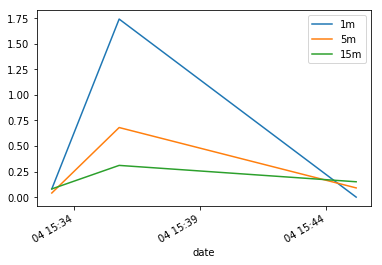

In [45]:
df.plot()

# おしまい